In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [ ]:
# Define column names
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1, 22)]
col_names = index_names + setting_names + sensor_names

# Load datasets
train = pd.read_csv('train_FD001.txt', sep='\s+', header=None, names=col_names)
test = pd.read_csv('test_FD001.txt', sep='\s+', header=None, names=col_names)
y_test = pd.read_csv('RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])

# Calculate RUL for train data
rul = train.groupby('unit_nr')['time_cycles'].max().reset_index()
rul.columns = ['unit_nr', 'max_cycles']
train = train.merge(rul, on='unit_nr', how='left')
train['RUL'] = train['max_cycles'] - train['time_cycles']
train.drop('max_cycles', axis=1, inplace=True)

# Scale the data
scaler = MinMaxScaler()
feature_columns = setting_names + sensor_names
train[feature_columns] = scaler.fit_transform(train[feature_columns])
test[feature_columns] = scaler.transform(test[feature_columns])


In [ ]:
rul_scaler = MinMaxScaler()
train['RUL'] = rul_scaler.fit_transform(train[['RUL']])

In [ ]:
# Function to create sliding windows
def create_sliding_windows(df, sequence_length=30):
    sequences = []
    targets = []
    for unit in df['unit_nr'].unique():
        unit_data = df[df['unit_nr'] == unit]
        for i in range(len(unit_data) - sequence_length):
            sequence = unit_data.iloc[i:i + sequence_length][feature_columns].values
            target = unit_data.iloc[i + sequence_length]['RUL']
            sequences.append(sequence)
            targets.append(target)
    return np.array(sequences), np.array(targets)

# Generate train sequences
sequence_length = 30
X_train, y_train = create_sliding_windows(train, sequence_length)

# Prepare test data: Use the last `30` rows for each unit in the test dataset
X_test = []
for unit in test['unit_nr'].unique():
    unit_data = test[test['unit_nr'] == unit].tail(sequence_length)
    X_test.append(unit_data[feature_columns].values)
X_test = np.array(X_test)  # Shape: (Number of units, 30, 24)


In [ ]:
# Define the LSTM model
model = Sequential([
    LSTM(32, input_shape=(sequence_length, len(feature_columns)), return_sequences=False),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Predict RUL
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])


C:\Users\Soham\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    verbose=1
)


Epoch 1/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0534 - mae: 0.1538 - val_loss: 0.0187 - val_mae: 0.0978
Epoch 2/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0106 - mae: 0.0759 - val_loss: 0.0179 - val_mae: 0.0957
Epoch 3/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0106 - mae: 0.0742 - val_loss: 0.0184 - val_mae: 0.0977
Epoch 4/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0103 - mae: 0.0722 - val_loss: 0.0170 - val_mae: 0.0940
Epoch 5/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0102 - mae: 0.0720 - val_loss: 0.0159 - val_mae: 0.0915
Epoch 6/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0098 - mae: 0.0694 - val_loss: 0.0155 - val_mae: 0.0903
Epoch 7/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0092 - mae: 0.0673 - val_loss: 0.0167 - val_mae: 0.0880
Epoch 8/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0082 - mae: 0.0634 - val_loss: 0.0157 - val_mae: 0.0842
Epoch 9/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - lo

In [ ]:
# Predict RUL for test dataset
scaled_rul_pred = model.predict(X_test)

# Inverse scale the predictions (if RUL was scaled during training)
rul_pred = rul_scaler.inverse_transform(scaled_rul_pred)

# Evaluate predictions
rul_actual = y_test.values.flatten()
print("Predicted RUL:", rul_pred.flatten())
print("Actual RUL:", rul_actual)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted RUL: [1.36384888e+02 1.46669327e+02 5.52432861e+01 8.79990005e+01
 1.15044189e+02 1.28492737e+02 1.03578232e+02 9.35065308e+01
 1.45433212e+02 1.01807098e+02 9.74930801e+01 9.61766739e+01
 8.21733246e+01 1.44210205e+02 1.00914619e+02 8.75448380e+01
 4.92350616e+01 3.50119934e+01 9.47494125e+01 1.27264690e+01
 6.35313339e+01 1.32846329e+02 1.53724274e+02 1.70012150e+01
 1.23433395e+02 1.23739510e+02 7.51420212e+01 1.14693733e+02
 1.08104134e+02 1.10949730e+02 7.31348038e+00 5.41435585e+01
 1.34725357e+02 1.61056817e-01 5.58002138e+00 1.86794930e+01
 2.63196259e+01 4.54078560e+01 1.50883881e+02 2.74139137e+01
 2.45133953e+01 9.55641460e+00 6.99614182e+01 1.05673798e+02
 9.05072403e+01 3.63596916e+01 1.40640121e+02 1.10935158e+02
 1.81208344e+01 8.43374176e+01 1.17147163e+02 3.16321392e+01
 2.71399345e+01 1.38796005e+02 1.39762604e+02 1.62260818e+01
 1.16224289e+02 4.69871254e+01 1.37861130e+02 1.36993835e+02
 1.92265263e+01 4.27258339e+01 8

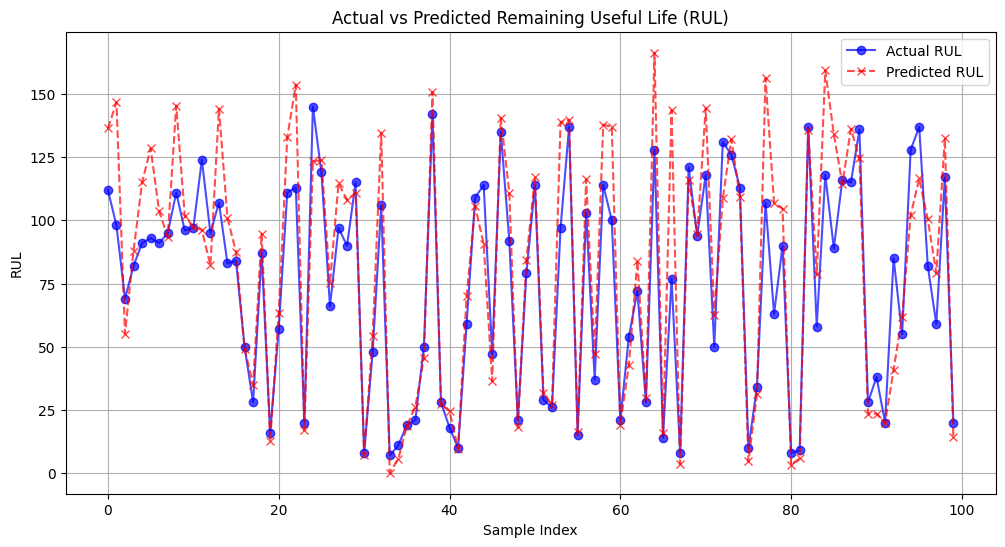

In [ ]:
import matplotlib.pyplot as plt

# Example data (Replace these with actual rul_pred and rul_actual from your code)
#rul_pred = rul_pred.flatten()
#rul_actual = rul_actual

# Plot Predicted vs Actual RUL
plt.figure(figsize=(12, 6))
plt.plot(rul_actual, label="Actual RUL", color="blue", marker='o', linestyle='-', alpha=0.7)
plt.plot(rul_pred, label="Predicted RUL", color="red", marker='x', linestyle='--', alpha=0.7)
plt.title("Actual vs Predicted Remaining Useful Life (RUL)")
plt.xlabel("Sample Index")
plt.ylabel("RUL")
plt.legend()
plt.grid(True)
plt.show()


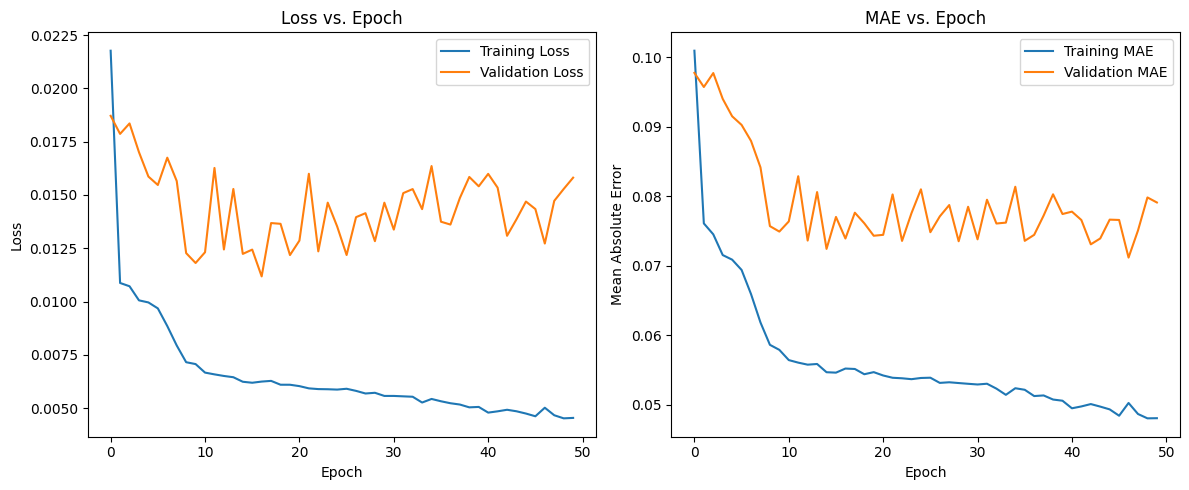

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot MAE vs Epoch
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Get the weights of the first layer
first_layer_weights = model.layers[0].get_weights()

# Print the weights and biases separately
if first_layer_weights:
    print("Weights of the first layer:")
    print(first_layer_weights[0])  # Weight matrix
    if len(first_layer_weights) > 1:
        print("Biases of the first layer:")
        print(first_layer_weights[1])  # Bias vector
else:
    print("The first layer has no weights.")


Weights of the first layer:
[[-0.03015016 -0.00565488  0.33767045 ...  0.10034981 -0.08564463
  -0.1014237 ]
 [-0.15018818 -0.0148073  -0.11781226 ...  0.09348699  0.04802569
  -0.00459858]
 [-0.17756604  0.04168364  0.00853968 ...  0.01696789  0.03638476
  -0.13671508]
 ...
 [-0.14171624 -0.11781472 -0.15093349 ... -0.10725524  0.11651061
  -0.16510402]
 [-0.05220356 -0.16611841  0.11131107 ...  0.0990601  -0.05649761
  -0.15348794]
 [ 0.00130246 -0.05013046  0.17300719 ...  0.01957002  0.2424787
  -0.07844863]]
Biases of the first layer:
[[ 0.04502423  0.18269853  0.19442132 ...  0.0429012  -0.07136742
  -0.0163688 ]
 [-0.24131268  0.10774719 -0.10798823 ... -0.04441541 -0.10413039
   0.48251858]
 [ 0.06177096 -0.03033397 -0.37561804 ...  0.04749165 -0.07286844
   0.11912342]
 ...
 [-0.00755323  0.06432449 -0.18975472 ... -0.17370029  0.04781085
   0.05143019]
 [ 0.18443392 -0.07560087 -0.09851946 ...  0.20218153 -0.20997582
  -0.05995942]
 [ 0.06370386 -0.11409359 -0.22570953 ...  0

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

In [ ]:
def permutation_importance(model, X_test, y_test, feature_columns):
    baseline = mean_squared_error(y_test, model.predict(X_test))
    importances = []

    for i, feature in enumerate(feature_columns):
        X_test_permuted = X_test.copy()
        np.random.shuffle(X_test_permuted[:, i])
        shuffled_score = mean_squared_error(y_test, model.predict(X_test_permuted))
        importances.append(baseline - shuffled_score)

    return dict(zip(feature_columns, importances))

feature_importances = permutation_importance(model, X_test, y_test, feature_columns)
sorted_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)
print("Feature importances:", sorted_importances)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Feature importances: [('s_6', 3.31689453125), ('se

The top 3 important features , ignoring the settings:

1. P15 - Pressure at fan inlet
2. P2 - Total pressure at bypass duct
3. P30 - Total pressure at HPC outlet



